# Handling Missing Data - continious features

In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb 
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu, pointbiserialr
from scipy.stats import chi2_contingency
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import math

In [13]:
#editor_fold
fill_na_ethnic=True # fill  'Other/Unknown' to null values in ethnich feature
output_path='output/missing_data/'
drop_apache=True
mpl.rcParams['axes.titlesize'] = 16  # You can adjust the size as needed
filter_continious_features=False
drop_irrelevant_cols=['encounter_id','patient_id','hospital_death',
                      'apache_4a_hospital_death_prob','apache_4a_icu_death_prob','readmission_status'] # drop irrelavnt cols

In [3]:
df=pd.read_csv('data/training_v2.csv')
target=df["hospital_death"]

###----------editor fold preprocessing-------------###

#go to fill_na_ethnic declaration
if fill_na_ethnic:
    df['ethnicity']=df['ethnicity'].fillna('Other/Unknown')


#keep continious features
if filter_continious_features:
    continious_columns= df.columns[(df.nunique() >=10) & ((df.dtypes == 'int64')|(df.dtypes == 'float64'))]
    df=df.loc[:,continious_columns]

#drop irrelavnt cols
df.drop(columns=drop_irrelevant_cols)

,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,118,68.0,22.730000,0,Caucasian,M,180.3,Floor,Floor,92,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,81,77.0,27.420000,0,Caucasian,F,160.0,Floor,Floor,90,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,118,25.0,31.950000,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,118,81.0,22.640000,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,30,75.0,23.060250,0,Caucasian,M,177.8,Acute Care/Floor,Floor,927,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,121,56.0,47.179671,0,Caucasian,F,183.0,Emergency Department,Floor,925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,195,48.0,27.236914,0,Caucasian,M,170.2,Emergency Department,Accident & Emergency,908,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,66,NaN,23.297481,0,Caucasian,F,154.9,Emergency Department,Accident & Emergency,922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [4]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [5]:
evaluation_dictionary={}
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

def bootstrap_confidence_interval(predictions, y_true, metric_func, n_iterations=1000, confidence_level=0.95):
    """
    Calculate bootstrap confidence intervals for a given metric.

    Parameters:
    - predictions: Model predictions.
    - y_true: True labels.
    - metric_func: Metric function to calculate (e.g., roc_auc_score).
    - n_iterations: Number of bootstrap iterations.
    - confidence_level: Confidence level for the interval.

    Returns:
    - A tuple containing the lower and upper bounds of the confidence interval.
    """

    scores = []
    for _ in range(n_iterations):
        # Bootstrap sample indices
        indices = np.random.choice(range(len(predictions)), size=len(predictions), replace=True)
        # Calculate and store the score
        score = metric_func(y_true[indices], predictions[indices])
        scores.append(score)

    # Calculate the confidence interval
    lower = np.percentile(scores, (1 - confidence_level) / 2 * 100)
    upper = np.percentile(scores, (1 + confidence_level) / 2 * 100)

    return lower, upper

def eval_technique_with_bootstrap(x_train, y_train, x_test, y_test, technique_name, n_iterations=1000):
    models = {
        'Random Forest': RandomForestClassifier(),
        'Logistic Regression': LogisticRegression(max_iter=1000)
    }
    x_train.reset_index()
    # Dictionary to store results
    results = {technique_name: {}}
    
    for model_name, model in models.items():
        model.fit(x_train, y_train)
        
        # For metrics requiring probabilities
        if hasattr(model, "predict_proba"):
            predictions_proba = model.predict_proba(x_test)[:, 1]
            auc_ci = bootstrap_confidence_interval(predictions_proba, y_test, roc_auc_score, n_iterations)
            results[technique_name][f'{model_name} AUC CI'] = auc_ci
        
        # For all metrics
        predictions = model.predict(x_test)
        accuracy_ci = bootstrap_confidence_interval(predictions, y_test, accuracy_score, n_iterations)
        f1_ci = bootstrap_confidence_interval(predictions, y_test, f1_score, n_iterations)
        
        results[technique_name][f'{model_name} Accuracy CI'] = accuracy_ci
        results[technique_name][f'{model_name} F1 Score CI'] = f1_ci
    
    # Update the global dictionary
    evaluation_dictionary.update(results)

    

## Intorduction
in the next chapter, we will demonstrate different methods for handling missing data, especially for continuous features. These techniques range from the most basic (dropping null rows, filling with -1) to more sophisticated approaches (using statistical methods, applying domain knowledge).



## 1. Naive techniques 
### 1.1 Dropping Missing Values:
1. first if we drop all the rows that contians null values, we keep only 33 rows, not a good solution
2. if we create a threshold, all the cols with cut-of 50 percents null values we drop them, and then we 

In [6]:
df_drop_nulls=df.dropna()
print(f"the post-filter null values df shape is :{df_drop_nulls.shape}")

the post-filter null values df shape is :(25, 186)


In [7]:
# Original DataFrame shape
original_shape = df.shape

# Step 1: Drop columns where more than 50% of the values are null
threshold = len(df) * 0.5  # 50% of the number of rows
df_drop_nulls = df.dropna(thresh=threshold, axis=1)

# Step 2: Remove any rows that still have null values
df_drop_nulls.dropna(inplace=True)

# New DataFrame shape after dropping nulls
new_shape = df_drop_nulls.shape

print(f"Original DataFrame shape: {original_shape}")
print(f"Shape after dropping columns with >50% nulls and rows with any nulls: {new_shape}")

Original DataFrame shape: (91713, 186)
Shape after dropping columns with >50% nulls and rows with any nulls: (28044, 112)


C:\Users\galbe\AppData\Local\Temp\ipykernel_17068\330005919.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_nulls.dropna(inplace=True)


### 1.2 Impute Central Tendency
Fill missing values with the median/mean value of the respective column.
ifi it non-coninious - mode

In [8]:
X_train, X_test, y_train, y_test = train_test_split( df, target, test_size=0.2, random_state=42)

medians = X_train.median()

# Apply the median values to fill missing values in both training and test sets
X_train_filled = X_train.fillna(medians)
X_test_filled = X_test.fillna(medians)

# eval_technique_with_bootstrap(X_train, y_train, X_test, y_test, technique_name="fill_median", n_iterations=1000)


C:\Users\galbe\AppData\Local\Temp\ipykernel_17068\1311877908.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  medians = X_train.median()


### 1.3 Stochastic single Imputation:
Fill missing values with a random selection from observed values in the respective column.

Random imputation involves filling missing values with randomly selected observed values from the same column. This technique can preserve the distribution of the variable but does not account for correlations between variables

*** tbd if it conitnious -- create distirbuion with mean and sstd and then take sample

In [9]:

# Assuming 'df' is your DataFrame and 'target' is your target variable
X = df.copy()
y = target

# Split the dataset into training and test sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply random imputation to the training set
for column in X_train.columns:
    # Get the observed (non-missing) values for the column in the training set
    observed_values_train = X_train[column].dropna().values
    
    # Randomly fill missing values in the training set
    if observed_values_train.size > 0:
        X_train[column] = X_train[column].apply(lambda x: np.random.choice(observed_values_train) if pd.isnull(x) else x)



for column in X_test.columns:
    # Use the observed (non-missing) values from the training set
    observed_values_train = X_train[column].dropna().values  # This should not include test set values
    
    # Randomly fill missing values in the test set based on training set observed values
    if observed_values_train.size > 0:
        X_test[column] = X_test[column].apply(lambda x: np.random.choice(observed_values_train) if pd.isnull(x) else x)

# eval_technique_with_bootstrap(X_train, y_train, X_test, y_test, technique_name='Stochastic single Imputation', n_iterations=1000)


### 1.5 mark Missing Data
we can mark missing data as -1
1. all the columns had positive number, expept 'pre_icu_los_days' so in this column we will use -100 instead -1 ( because the min level is -25)

In [10]:
#find each column has negative values
columns_with_negatives = [col for col in df.columns if (df[col] < 0).any()]

print("Columns with negative values:", columns_with_negatives)

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
df_impute_by_neg_one=df.copy()
df_impute_by_neg_one['pre_icu_los_days'].fillna(-100,inplace=True)
df_impute_by_neg_one.fillna(-1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_impute_by_neg_one, y, test_size=0.2, random_state=42)



### 1.6 Single Imputation - Imputation by Predictive Models (Parametric Approach)

This is a specific strategy for imputing missing values. In this approach, you build statistical models, often regression models, to predict the missing values based on the values of other observed variables

This parametric approach is more complex than simple imputation methods (e.g., mean, median imputation), but it can be powerful because it takes into account the relationships between variables when imputing missing data. It's especially useful when the missingness is not completely random, and there is some systematic relationship between the missing values and the observed data

*** 

In [ ]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
X=df.copy()
y=target
# Split the dataset into training and test sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2: Build XGBoost models for imputation
models = {}  # Dictionary to store the trained models
columns_with_missing =columns_with_missing = df.columns[df.isna().any()].tolist()

for column in columns_with_missing:
    # Create a copy of the training data with the target column to impute
    train_data = X_train.dropna(subset=column)
    
    # Define the features (X) and target (y)
    X_train_col = train_data.drop(columns=[column])
    y_train_col = train_data[column]
    
    # Create and train an XGBoost regressor model
    model = XGBRegressor(n_estimators=2,max_depth=1)
    model.fit(X_train_col, y_train_col)
    
    # Store the trained model
    models[column] = model



In [ ]:
X_train.isna().sum().sum()

In [114]:
count=0
for dataset in [X_train,X_test]:
    for index, row in dataset.iterrows():
        # Iterate over columns with missing values

        for column in columns_with_missing:
            # Check if the current value is null
            if pd.isnull(row[column]):
                count+=1
                print(count)
                # Prepare the input for the model (exclude the target column)
                model_input = row.drop(labels=[column]).values.reshape(1, -1)
                # Retrieve the model from the dictionary
                model = models[column]
                # Predict the missing value
                predicted_value = model.predict(model_input)[0]
                # Replace the null value in the dataframe
                df.at[index, column] = predicted_value

1


c:\Users\galbe\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# eval_technique_with_bootstrap(X_train, y_train, X_test, y_test, technique_name='Imputation by Predictive Models', n_iterations=1000)


### 1.7 multiple Imputation - Imputation by Predictive Models (Parametric Approach)


In [108]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X=df.copy()
y=target
# 1. Split the dataset into training and test sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Identify the missing values and create a mask for them
missing_mask_train = X_train.isna()
missing_mask_test = X_test.isna()

#3. Instantiate the MICE imputer with the desired parameters
imputer = IterativeImputer(random_state=100, max_iter=1)
imputer.fit(X_train)

#4. Fit the imputer on the data and transform it to obtain the imputed values
X_train_imputed=imputer.transform(X_train)
X_test_imputed=imputer.transform(X_test)

#5. Replace the missing values in the original dataset with the imputed values
X_train[missing_mask_train] = X_train_imputed[missing_mask_train]
X_test[missing_mask_test] = X_test_imputed[missing_mask_test]


# eval_technique_with_bootstrap(X_train, y_train, X_test, y_test, technique_name='mice imputation', n_iterations=1000)



c:\Users\galbe\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


NameError: name 'output_path' is not defined

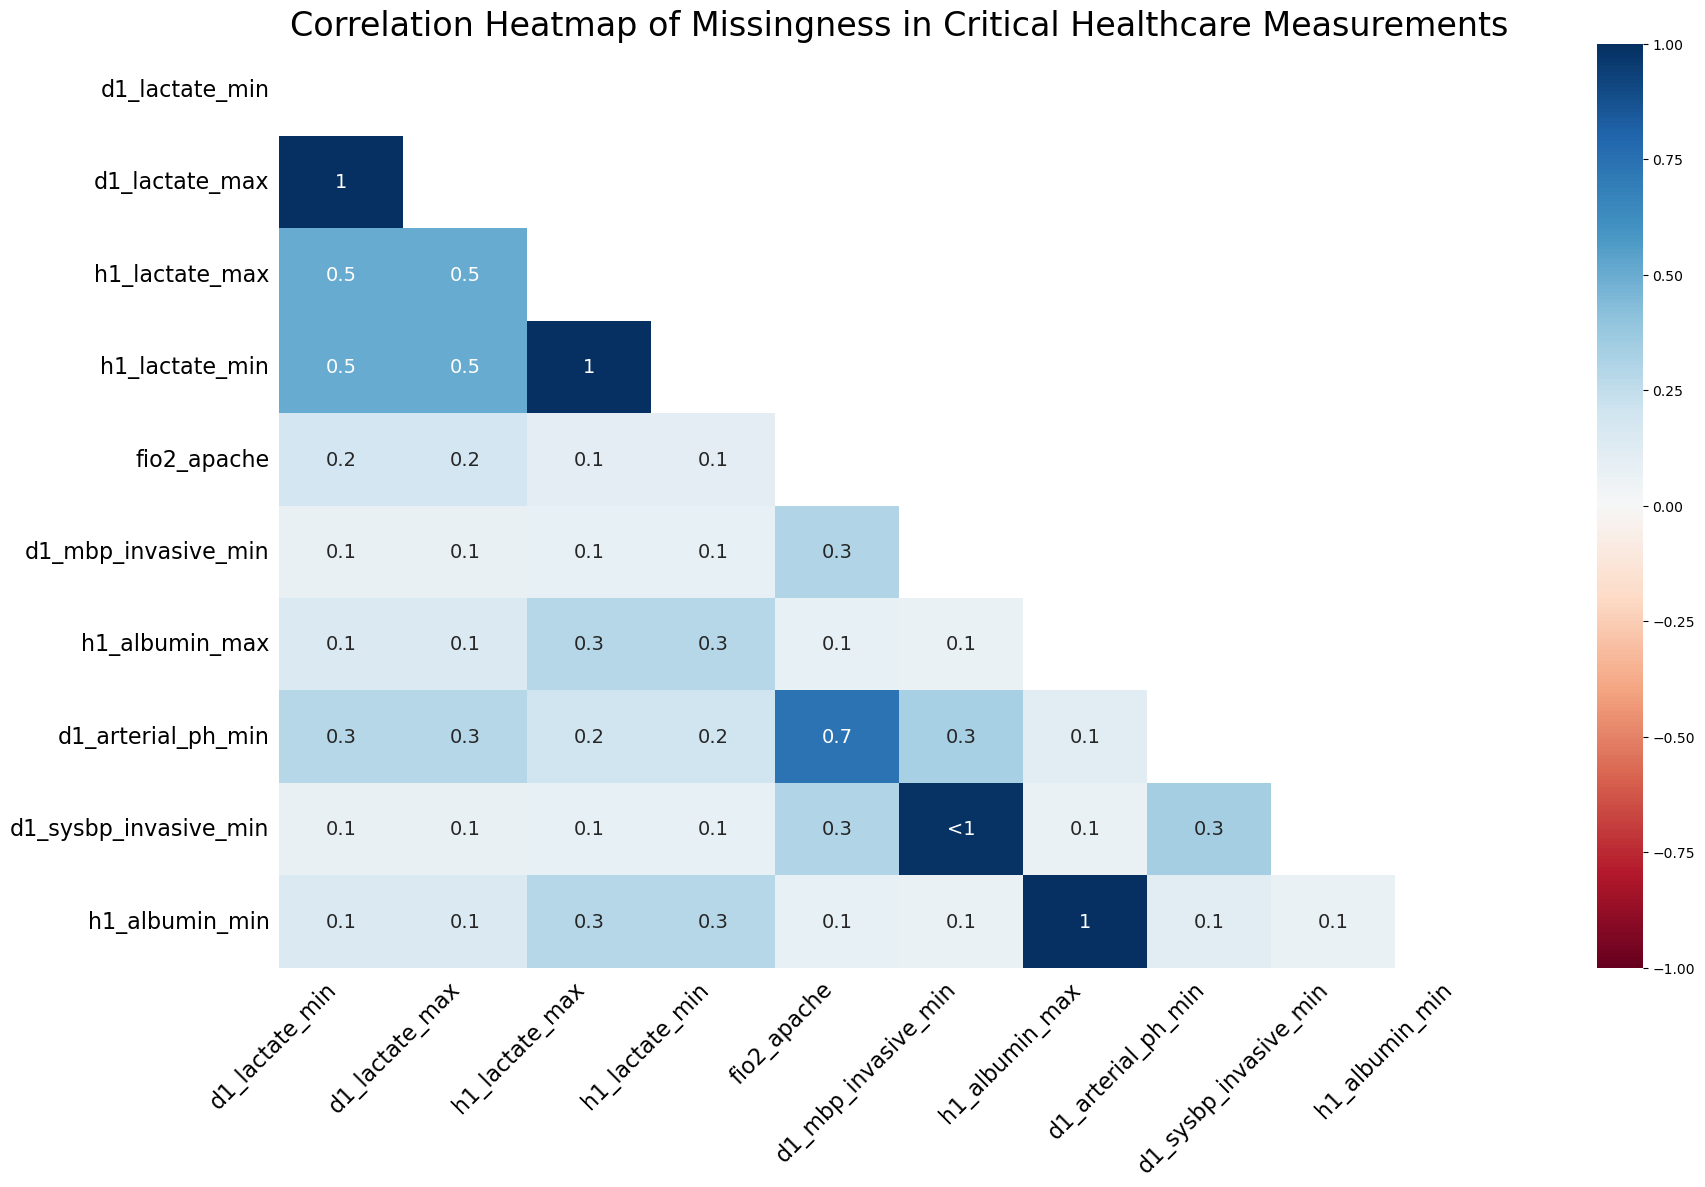

In [11]:
import missingno as msno
import pandas as pd
from statsmodels.stats.multitest import multipletests
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

df=pd.read_csv('data/training_v2.csv')
target=df["hospital_death"]

# Heatmap to show the correlation of missingness between variables
high_correlated_cols=['d1_lactate_min', 'd1_lactate_max', 'h1_lactate_max', 'h1_lactate_min',
       'fio2_apache', 'd1_mbp_invasive_min', 'h1_albumin_max',
       'd1_arterial_ph_min', 'd1_sysbp_invasive_min', 'h1_albumin_min']
msno.heatmap(df.loc[:,high_correlated_cols])
plt.title("Correlation Heatmap of Missingness in Critical Healthcare Measurements",size=24)
plt.savefig(os.path.join(output_path,'missing_values_cor.png'),bbox_inches='tight')

plt.show()


In [ ]:
# Initialize a list to store the correlation data
correlation_data = []
cols=df.columns
df_null=df.isnull()
# Loop over each column as the first column in the pair
for i, col1 in enumerate(cols):
    # Loop over each column as the second column in the pair, starting from the next column in the list
    for col2 in cols[i+1:]:
        # Check if col1 and col2 are not the same
        if col1 != col2:
            # Calculate the correlation of missingness between col1 and col2
            missing_corr = df_null.loc[:,[col1,col2]].corr().values[0][1]
            correlation_data.append({'column_1': col1, 'column_2': col2, 'corr': missing_corr})

# Convert the list of correlation data into a DataFrame
correlation_df = pd.DataFrame(correlation_data)


In [ ]:
def compare_distributions(df, col, target, ratio_median):
    group1 = df[df[col].notnull()][target].dropna()
    group2 = df[df[col].isnull()][target].dropna()
    if len(group1) > 100 and len(group2) > 100:
        if ((group1.median()/(group2.median()+0.01) > ratio_median) | (group2.median()/(group1.median()+0.01) > ratio_median)):
            stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
            return p
    return None

def find_null_values_corr(target, ratio_median, df):
    p_values = []
    columns_tested = []

    for col in df.columns:
        if col != target:
            p = compare_distributions(df, col, target, ratio_median)
            if p is not None:
                p_values.append(p)
                columns_tested.append(col)

    if len(p_values) == 0:
        return 'skip', 'skip', 'skip'

    rejections, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

    # Combine columns and corrected p-values into a DataFrame
    results_df = pd.DataFrame({
        'Column': columns_tested,
        "p_values":p_values,
        'Corrected P-Value': corrected_p_values,
        "rejections":rejections
    })

    # Sort by corrected p-values
    sorted_results = results_df.sort_values(by='Corrected P-Value')

    # Select the three lowest p-values and their columns
    lowest_p_values = sorted_results.head(3)

    if not lowest_p_values.empty:
        for index, row in lowest_p_values.iterrows():
            print(f"Column: {row['Column']}, Corrected P-Value: {row['Corrected P-Value']:.4f}")
    else:
        print("No significant changes in the distribution of {target} based on null presence were found after FDR correction.")

    # Return the three lowest corrected p-values and their corresponding columns
    return lowest_p_values['Column'].tolist(), lowest_p_values['Corrected P-Value'].tolist(), lowest_p_values["rejections"],lowest_p_values["p_values"]


In [ ]:

# Create a new column in the DataFrame to indicate the presence or absence of null values in 'd1_lactate_min'
def plot_box_plot_over_null(significant_differences,corrected_p_values,rejections,df,target):
    columns_of_interest=significant_differences
    p_values=corrected_p_values

    # Number of plots
    num_plots = len(columns_of_interest)

    # Define grid size for subplots (aim for a square layout)
    num_rows = math.ceil(math.sqrt(num_plots))
    num_cols = math.ceil(num_plots / num_rows)

    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 7, num_rows * 5))
    fig.tight_layout(pad=5.0)

    # Flatten axes array if there's more than one row and column for easier indexing
    if num_rows > 1 and num_cols > 1:
        axes = axes.flatten()
    colors = ["#89CFF0", "#F08080"]  # Soft blue for non-null, soft red for null

    # Iterate over each column of interest and create a subplot
    for idx, (col, fdr_p) in enumerate(zip(columns_of_interest, p_values)):
        df_nul = df.copy()
        df_nul[f'{col}_null'] = np.where(df_nul[col].isnull(), 'Null', 'No Null')
        
        # Calculate the number of observations in each group
        num_non_null = df_nul[df_nul[col].notnull()].shape[0]
        num_null = df_nul[df_nul[col].isnull()].shape[0]
        
        # Select the current axis for plotting
        ax = axes[idx] if num_plots > 1 else axes
        
        # Plot on the selected axis
        sb.boxplot(x=f'{col}_null', y=target, data=df_nul, ax=ax, palette=colors,showfliers=False)
        
        # Adding legend manually
        handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(2)]
        labels = [f'No Null (n={num_non_null})', f'Null (n={num_null})']
        ax.legend(handles, labels, loc='upper right' ,fontsize=13)
        target_title = target.capitalize()  # This capitalizes the first letter and makes the rest lowercase

        ax.set_title(f'{target_title} distribution corresponding {col} \n P-value:{np.round(fdr_p,3)}')
        ax.set_xlabel('')
        ax.set_ylabel(target_title, fontsize=16)  # Set y-axis label font size
        
        # Set font size for x-tick and y-tick labels
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        # Increase the y-axis limit a little bit
        current_bottom, current_top = ax.get_ylim()
        ax.set_ylim(current_bottom, current_top * 1.2)  # Increase the top limit by 10%
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(os.path.join(output_path,f'{target}_vs_null_values.png'),bbox_inches='tight')
    # Show plot
    plt.show()
    return

Column: d1_glucose_max, Corrected P-Value: 0.0000
Column: d1_glucose_min, Corrected P-Value: 0.0000
Column: d1_spo2_max, Corrected P-Value: 0.0087


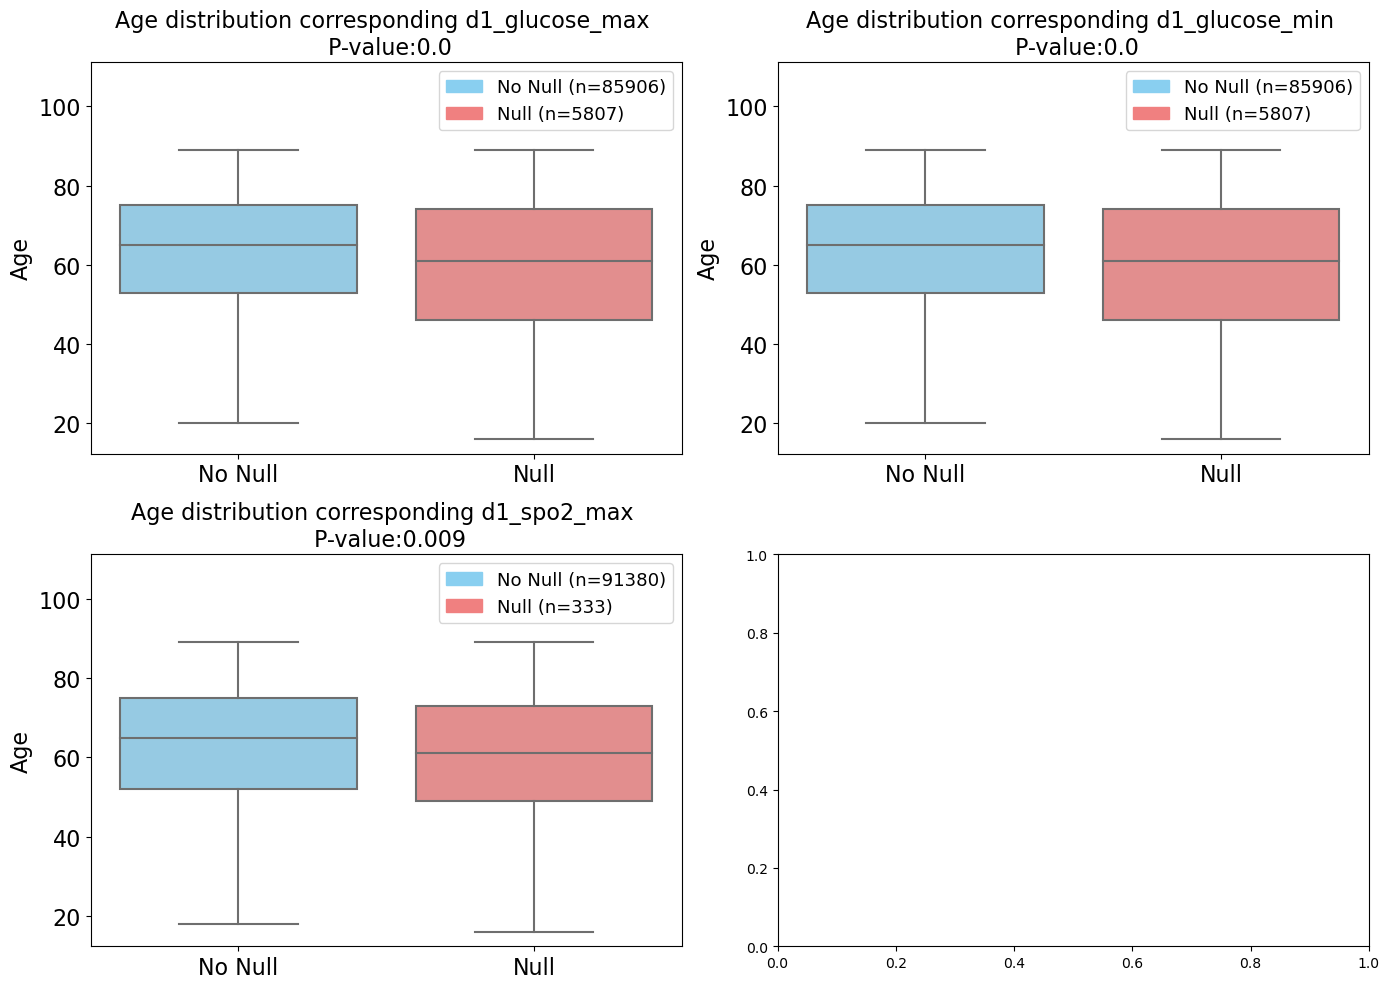

In [14]:
target='age'
raio_median=1.05
significant_differences,corrected_p_values,rejections,_=find_null_values_corr(target,raio_median,df)
if significant_differences!='skip':
    plot_box_plot_over_null(significant_differences,corrected_p_values,rejections,df,target)

Column: age, Corrected P-Value: 0.0000
Column: d1_sysbp_noninvasive_max, Corrected P-Value: 0.0000
Column: d1_sysbp_noninvasive_min, Corrected P-Value: 0.0000


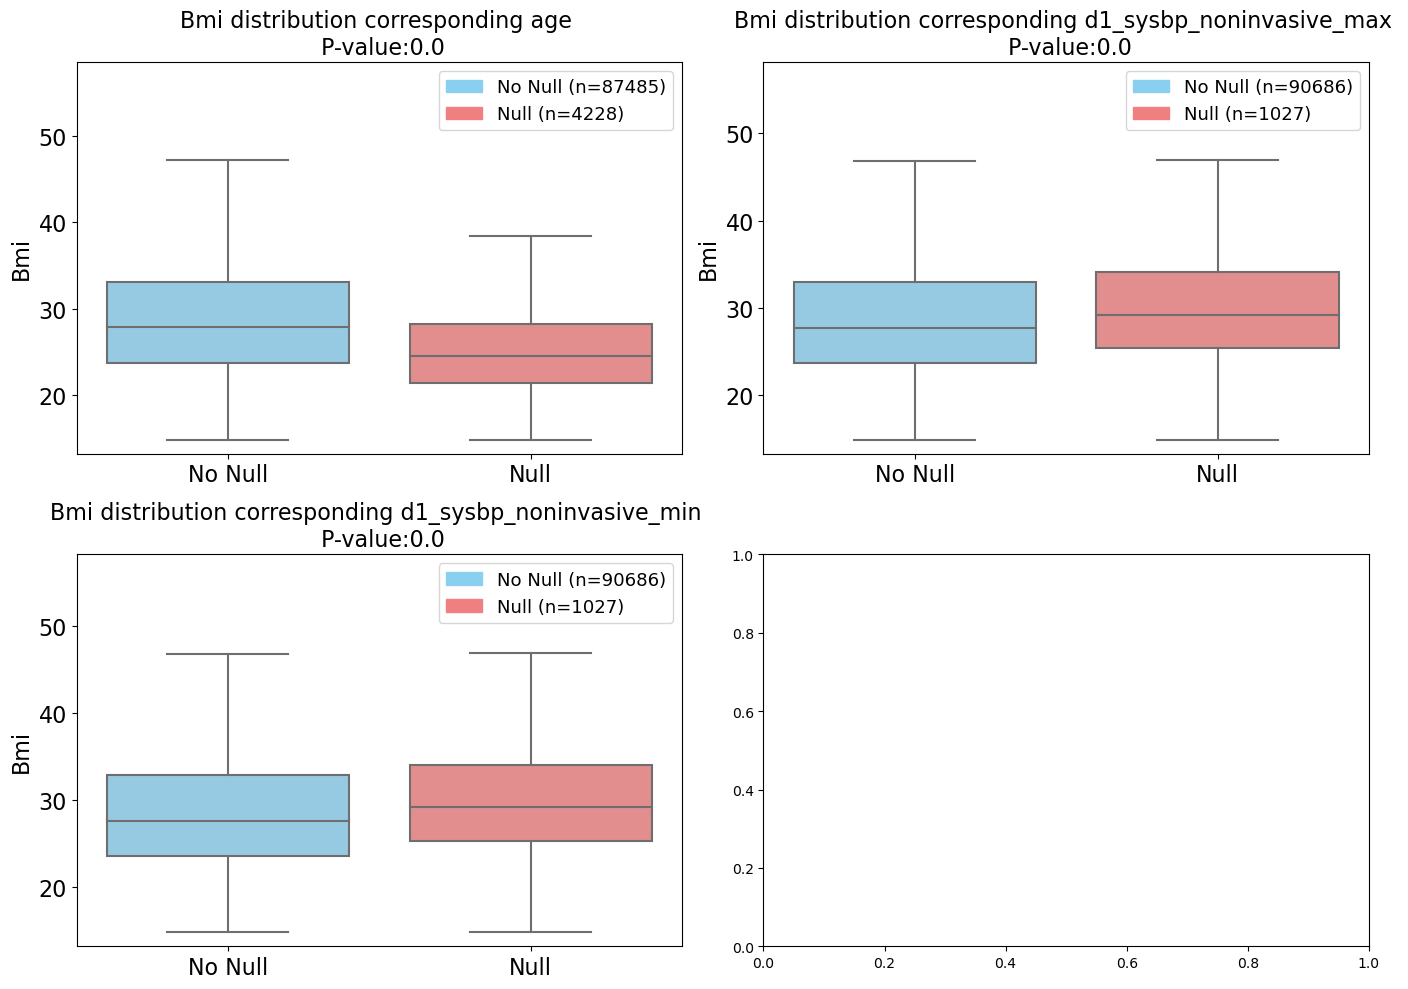

In [15]:
target='bmi'
ratio_median=1.05
significant_differences,corrected_p_values,rejections,_=find_null_values_corr(target,ratio_median,df)
plot_box_plot_over_null(significant_differences,corrected_p_values,rejections,df,target)

Column: age, Corrected P-Value: 0.0000
Column: d1_diasbp_noninvasive_max, Corrected P-Value: 0.0000
Column: d1_diasbp_noninvasive_min, Corrected P-Value: 0.0000


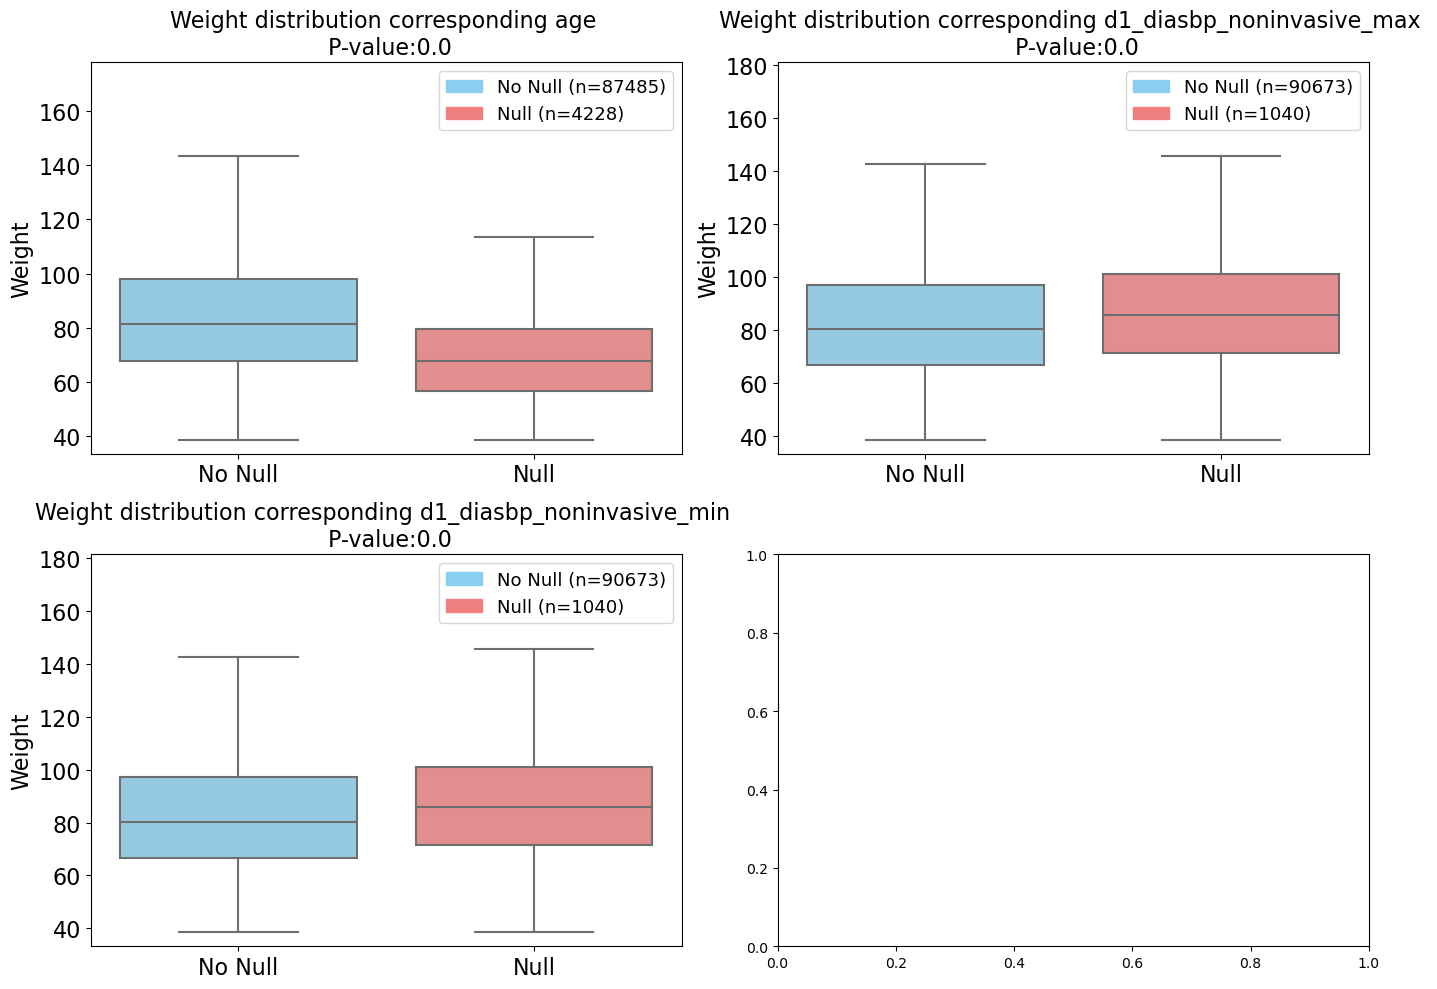

In [16]:
target='weight'
ratio_median=1.06
significant_differences,corrected_p_values,rejections,_=find_null_values_corr(target,ratio_median,df)
plot_box_plot_over_null(significant_differences,corrected_p_values,rejections,df,target)

Column: d1_diasbp_invasive_max, Corrected P-Value: 0.0000
Column: d1_diasbp_invasive_min, Corrected P-Value: 0.0000
Column: d1_mbp_invasive_max, Corrected P-Value: 0.0000


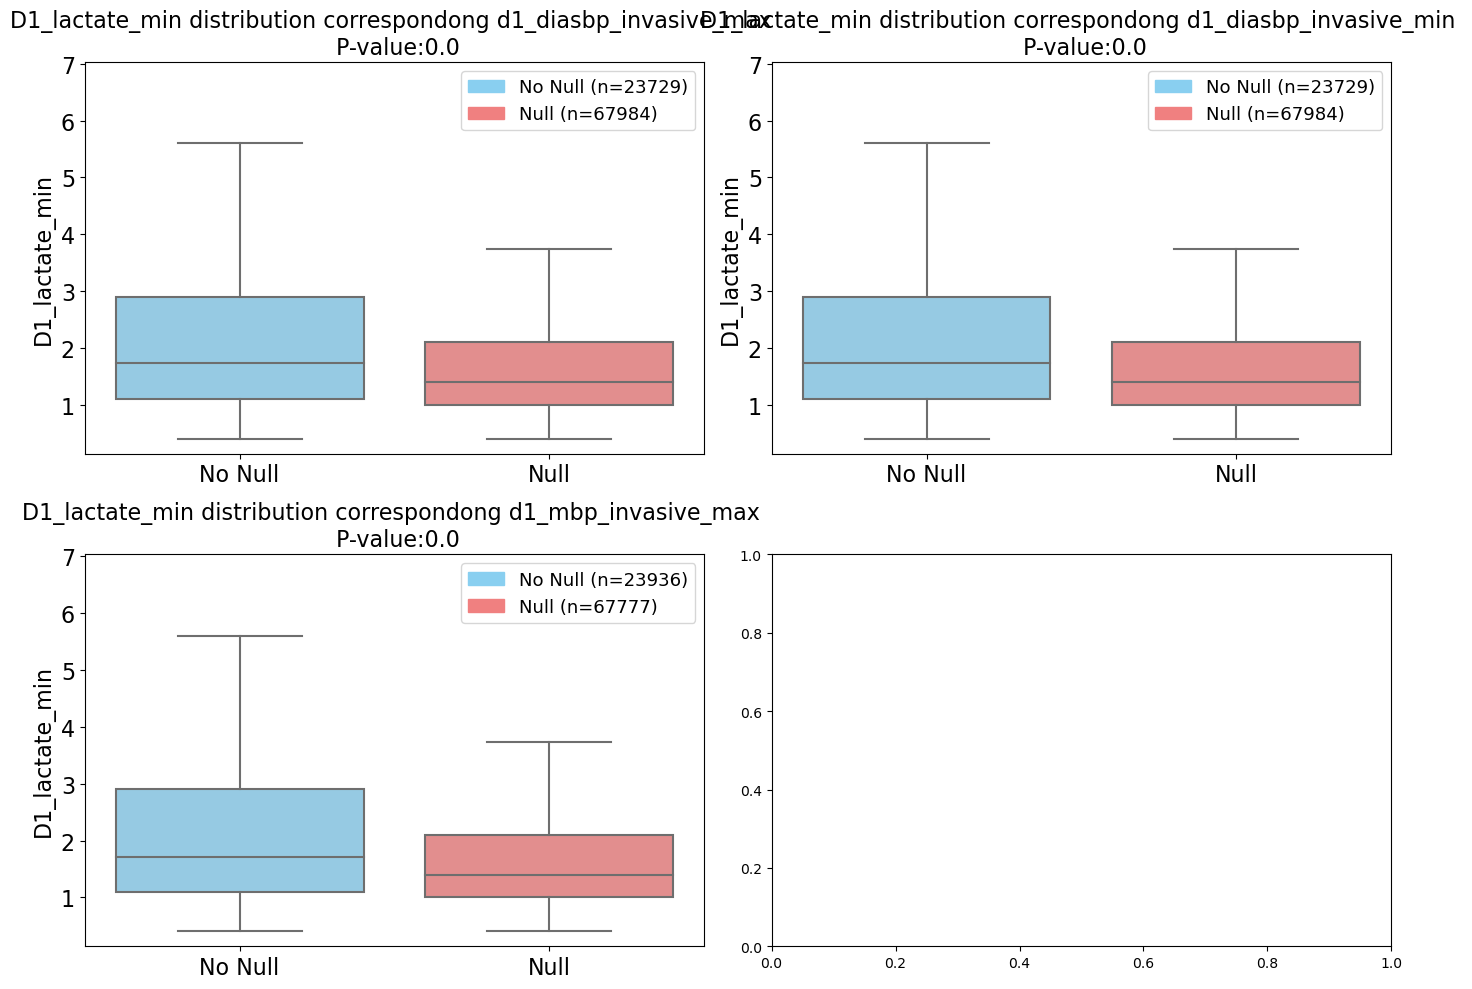

In [ ]:
target='d1_lactate_min'
ratio_median=1.21
significant_differences,corrected_p_values,rejections,_=find_null_values_corr(target,ratio_median,df)
plot_box_plot_over_null(significant_differences,corrected_p_values,rejections,df,target)